# Insper
# Informação Georreferenciada
# Exercício - Análise de Pontos


O conhecido mapa da cólera de John Snow é frequentemente citado como um dos primeiros exemplos do uso da pesquisa geográfica e análise espacial para entender uma epidemia. Começando em 31 de agosto de 1854, um surto de cólera atingiu o distrito de Londres chamado *Soho*. Ao longo de três dias, 127 pessoas morreram da doença e, em 10 de setembro, mais de 500 haviam morrido. Esta investigação usou técnicas de análise que hoje provavelmente envolveriam o uso de Sistemas de Informações Geográficas (SIGs). A análise de Snow demonstra o poder dos mapas e das informações subjacentes para visualizar e resolver problemas complicados.


A cólera se espalhou para as Ilhas Britânicas no início da década de 1830 devido à falta de saneamento e equívocos sobre suas causas. Hoje sabemos que a doença é causada por uma bactéria e geralmente é transmitida através de água potável contaminada. **O médico conseguiu, através da conversa com os moradores locais e sua análise espacial das mortes por cólera, determinar que sua suspeita sobre a origem da doença era realmente verdadeira, uma bomba de água na Broad Street**. Snow mapeou os locais dos poços de água locais e as mortes de cólera para apoiar seu argumento sobre a bomba contaminada, convencendo o conselho local a remover a alça para impedir seu uso.


O mapa de Snow, demonstrando o agrupamento espacial de mortes por cólera ao redor do poço de Broad Street, forneceu forte evidência em apoio à sua teoria de que a cólera era uma doença transmitida pela água.

Neste exercício vamos reproduzir o trabalho de John Snow. Faremos uso das principais técnicas para análises de pontos, que hoje são facilmente executadas por meio de ferramentas computacionais, mas que demonstram a vanguarda e pioneirismo de Snow.

Este código executa no **Google Colab**, mas fique à vontade para executá-lo em sua máquina.


---


### Passo 0: Instale os pacotes necessários:

In [ ]:
!pip install geopandas geopy pointpats fiona pygeos


### Importe as bibliotecas necessárias



In [2]:

import numpy as np #para processamento numérico em Python
import matplotlib.pyplot as plt #para os gráficos
import geopandas as gpd #para a leitura de shapefiles
import seaborn as sns #para fazer o mapa de kernel
from matplotlib.patches import Ellipse #para projetar a elipse

# pointpats --> análise espacial de pontos
from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse
from pointpats import PointPattern
import pointpats.quadrat_statistics as qs
from pointpats.distance_statistics import G, F, K, Genv, Fenv, Kenv
from pointpats import PoissonPointProcess


/Users/fran-janela/Documents/Insper/8o/InfoGeo/aulas/env/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/var/folders/9t/_sm_x0m957lf5z6q_l21z3dm0000gn/T/ipykernel_985/753617912.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get spe

### Exercício 1:

Faça upload do colab dos arquivos shape (Pumps, Cholera_Deaths) e na sequência faça a leitura deles por meio do Geopandas.

In [3]:
pumps = gpd.read_file('data/Pumps.shp')
pumps.head(5)

,Id,geometry
0,0,POINT (529396.539 181025.063)
1,0,POINT (529192.538 181079.391)
2,0,POINT (529183.740 181193.735)
3,0,POINT (529748.911 180924.207)
4,0,POINT (529613.205 180896.804)


In [4]:
cholera_deaths = gpd.read_file('data/Cholera_Deaths.shp')
cholera_deaths.head(5)

,Id,Count,geometry
0,0,3,POINT (529308.741 181031.352)
1,0,2,POINT (529312.164 181025.172)
2,0,1,POINT (529314.382 181020.294)
3,0,1,POINT (529317.380 181014.259)
4,0,4,POINT (529320.675 181007.872)


### Exercício 2:

Verifique os sistemas de coordenadas usados para as bombas de água e para as mortes. O que você pode dizer sobre ele, considerando que estamos nos referindo a Londres?

In [5]:
print(f"Pumps CSR: {pumps.crs}")
print(f"Cholera Deaths CSR: {cholera_deaths.crs}")

Pumps CSR: EPSG:27700
Cholera Deaths CSR: EPSG:27700


**Resposta:** O Sistema de Coordenadas `EPSG:27700` diz respeito à OSGB36 (British National Grid -- United Kingdom Ordnance Survey), ou seja, é o sistema de coordenadas que melhor se aplica à nossa área de estudo que é Londres, e o elipsoide é o Airy 1830. Além disso a unidade de medida é em metros.

### Exercício 3

Faça um gráfico com as bombas (em vermelho) e as mortes (em preto). A figura deve ter tamanho (10,8).

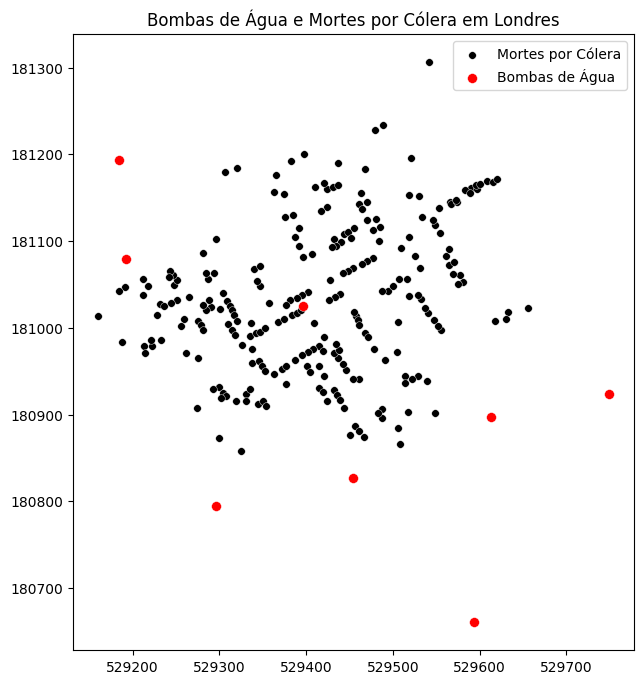

In [6]:
fig, grafico = plt.subplots(figsize=(10, 8))
cholera_deaths.plot(ax=grafico, color='black', edgecolor="white", markersize=30, linewidth=0.3, label='Mortes por Cólera')
pumps.plot(ax=grafico, color='red', edgecolor='white', linewidth=0.3, markersize=50, label='Bombas de Água')
grafico.set_title('Bombas de Água e Mortes por Cólera em Londres', fontsize=12)
plt.legend()
plt.show()

### Exercício 4: 

Extraia a longitude (x) e latitude (y) a partir da coluna geometry do shapefile Cholera_Deaths e, com uso destes dois, crie um objeto do tipo PointPattern para que possa executar as principais análises envolvendo pontos.

In [7]:
x = cholera_deaths['geometry'].x
y = cholera_deaths['geometry'].y

pontos = np.vstack((x, y)).T

pp = PointPattern(pontos)

pp.points

/Users/fran-janela/Documents/Insper/8o/InfoGeo/aulas/env/lib/python3.11/site-packages/libpysal/cg/shapes.py:1492: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/fran-janela/Documents/Insper/8o/InfoGeo/aulas/env/lib/python3.11/site-packages/libpysal/cg/shapes.py:1208: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


,x,y
0,529308.741420,181031.351546
1,529312.163571,181025.172401
2,529314.382429,181020.293688
3,529317.379645,181014.258771
4,529320.675449,181007.871628
...,...,...
245,529362.664552,181156.058382
246,529365.151891,181176.128560
247,529274.165044,180907.312598
248,529299.361335,180873.184663


### Exercício 5:

Calcule o **Centro Médio** e Projete

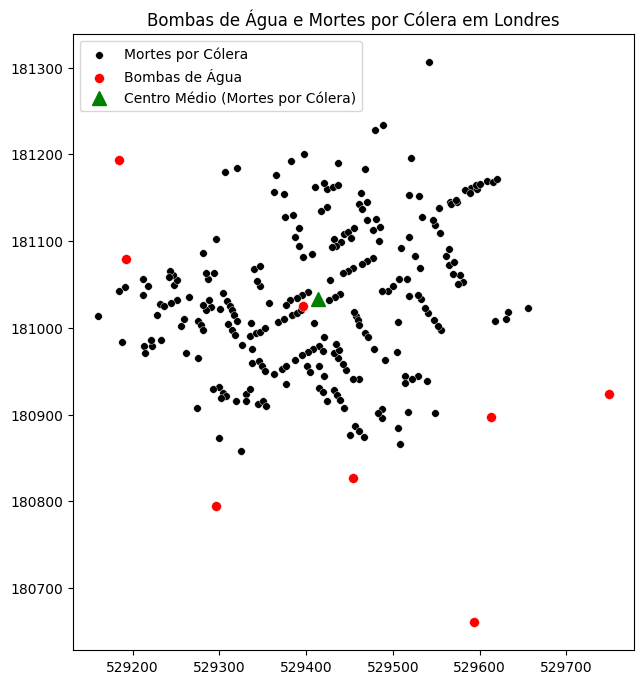

In [8]:
mc = mean_center(pp.points)

fig, grafico = plt.subplots(figsize=(10, 8))
cholera_deaths.plot(ax=grafico, color='black', edgecolor="white", markersize=30, linewidth=0.3, label='Mortes por Cólera')
pumps.plot(ax=grafico, color='red', edgecolor='white', linewidth=0.3, markersize=50, label='Bombas de Água')
plt.plot(mc[0], mc[1], 'g^', label='Centro Médio (Mortes por Cólera)', markersize=10)
grafico.set_title('Bombas de Água e Mortes por Cólera em Londres', fontsize=12)
plt.legend()
plt.show()

### Exercício 6: 

Calcule a **distância padrão** e projete o círculo de distância padrão

In [9]:
stdd = std_distance(pp.points)
print(f"Distância Padrão: {stdd}")

Distância Padrão: 137.09593350245717


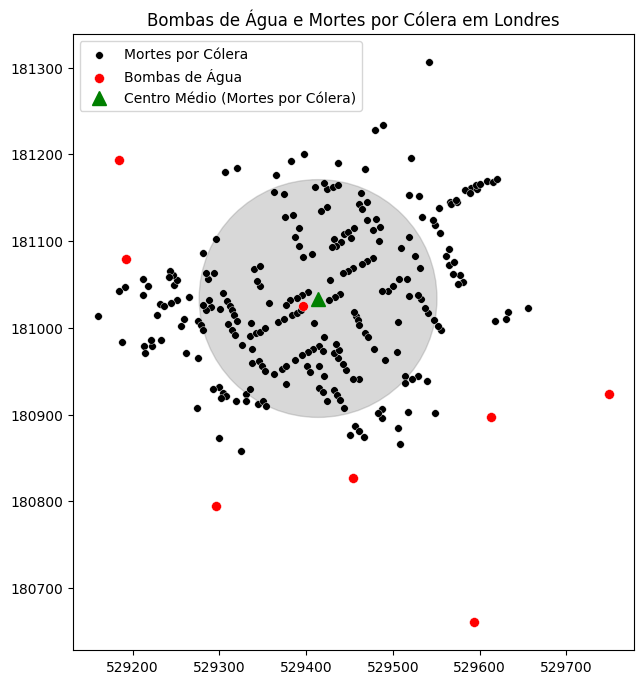

In [10]:
fig, grafico = plt.subplots(figsize=(10, 8))
circle_std=plt.Circle((mc[0], mc[1]),stdd,color='gray', alpha = 0.3)
grafico.add_artist(circle_std)
cholera_deaths.plot(ax=grafico, color='black', edgecolor="white", markersize=30, linewidth=0.3, label='Mortes por Cólera')
pumps.plot(ax=grafico, color='red', edgecolor='white', linewidth=0.3, markersize=50, label='Bombas de Água')
plt.plot(mc[0], mc[1], 'g^', label='Centro Médio (Mortes por Cólera)', markersize=10)
grafico.set_title('Bombas de Água e Mortes por Cólera em Londres', fontsize=12)
plt.legend()
plt.show()

### Exercício 7:

Calcule e projete a elipse padrão

In [11]:
sx, sy, theta = ellipse(pp.points)
theta_degree = np.degrees(theta)

elipse = Ellipse(xy=mc,
                 width=sx*2,
                 height=sy*2,
                 angle = -theta_degree,
                 color='grey',
                 alpha = 0.2)

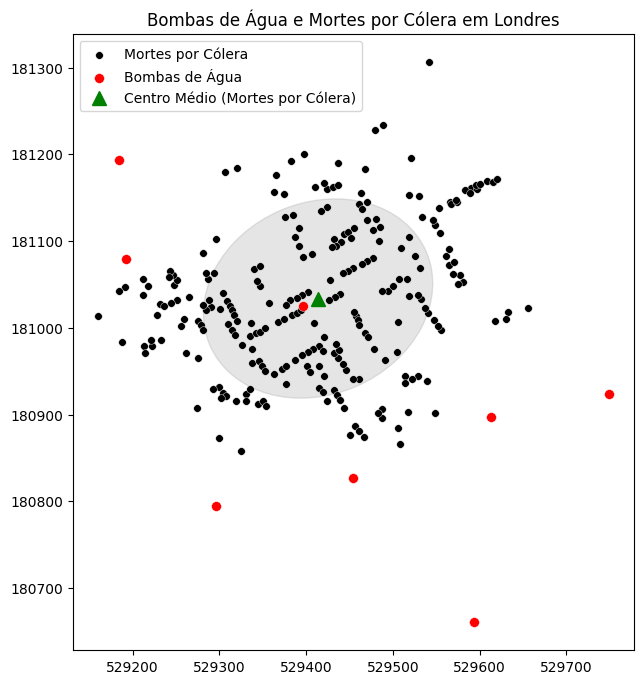

In [12]:
fig, grafico = plt.subplots(figsize=(10, 8))
grafico.add_artist(elipse)
cholera_deaths.plot(ax=grafico, color='black', edgecolor="white", markersize=30, linewidth=0.3, label='Mortes por Cólera')
pumps.plot(ax=grafico, color='red', edgecolor='white', linewidth=0.3, markersize=50, label='Bombas de Água')
plt.plot(mc[0], mc[1], 'g^', label='Centro Médio (Mortes por Cólera)', markersize=10)
grafico.set_title('Bombas de Água e Mortes por Cólera em Londres', fontsize=12)
plt.legend()
plt.show()

### Exercício 8 - Quadrats: 

Calcule e projete o Quadrats retangulares, 3x3

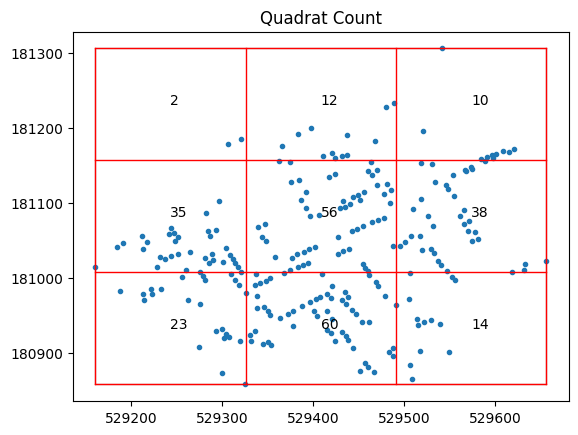

In [13]:
quadrats_monumentos = qs.QStatistic(pp, shape='rectangle', nx=3, ny=3)

quadrats_monumentos.plot()

### Exercício 9 - Densidade: 

Faça um **Mapa de Kernel** para estes pontos

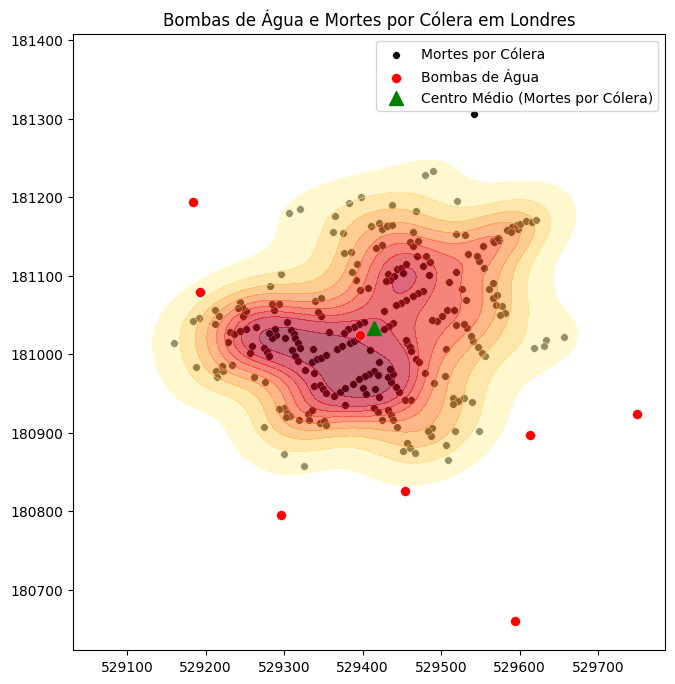

In [14]:
fig, grafico = plt.subplots(figsize=(10, 8))
cholera_deaths.plot(ax=grafico, color='black', edgecolor="white", markersize=30, linewidth=0.3, label='Mortes por Cólera')
sns.kdeplot(x=pontos[:,0], y=pontos[:,1], fill=True, cmap='YlOrRd', ax=grafico, alpha=0.6)
pumps.plot(ax=grafico, color='red', edgecolor='white', linewidth=0.3, markersize=50, label='Bombas de Água')
plt.plot(mc[0], mc[1], 'g^', label='Centro Médio (Mortes por Cólera)', markersize=10)
grafico.set_title('Bombas de Água e Mortes por Cólera em Londres', fontsize=12)
plt.legend()
plt.show()

### Exercício 10 - K de Ripley: 

Calcule a função K, e os envelopes de confiança com 2000 iterações (CSR)

/Users/fran-janela/Documents/Insper/8o/InfoGeo/aulas/env/lib/python3.11/site-packages/libpysal/cg/shapes.py:1923: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)
/Users/fran-janela/Documents/Insper/8o/InfoGeo/aulas/env/lib/python3.11/site-packages/libpysal/cg/shapes.py:103: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  warnings.warn(dep_msg, FutureWarning)


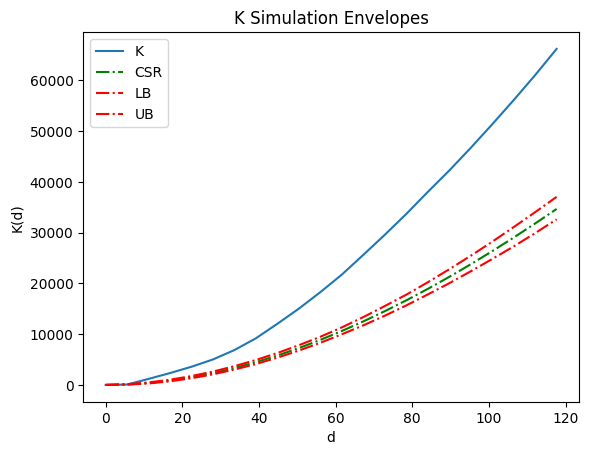

In [15]:
realizations = PoissonPointProcess(pp.window, pp.n, 2000, asPP = True)

kenv = Kenv(pp, intervals=20, realizations=realizations)
kenv.plot()

## Conclusão

Analisando o resultado obtido pelas operações estatísticas feitas acima, nota-se que os pontos de mortes de cólera em Londres não seguem uma distribuição aleatória, uma vez que a linha K está significativamente acima do envelopamento calculado. Isso indica a presença de um cluster, e ao analisar os outros mapas obtidos, pode-se afirmar que existe uma bomba de água que está no centro desse Cluster. Assim, assim como John Snow percebeu na época, a bomba em questão precisa ser interditada.